On utilise depuis peu le bloc de colonnes B_... de la table borrowers pour gérer les contentieux.
Ce bloc n'est plus accessible depuis assez longtemps.

Questions :
- on sait que ce bloc contient des informations autres que celles relatives aux contentieux => les identifier, pour éventuellement les supprimer ou les récuperer dans un autre bloc
- une fois que l'adhérent n'est plus en contentieux, les infos relatives au contentieux doivent être supprimées. Cela n'a jamais été fait, mettre au point une méthode d'analyse pour identifier les cartes concernées.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import date

from kiblib.utils.db import DbConn

import requests
import json

In [3]:
def mod_borrower(userid, data):
    api_url = "http://cataloguekoha.ntrbx.local/cgi-bin/koha/rest.pl/user"
    url = f"{api_url}/{userid}"
    data = json.dumps(data)
    data2mod = f"data={data}"
    print(data2mod)
    response = requests.put(url, data=data2mod)
    print(f"{userid} : {response.content}")

In [2]:
db_conn = DbConn().create_engine()

# Préparation des données
- on part de la table borrowers pour créer un dataframe "adherents"
- création du dataframe "adh_bloc_ctx" : on ne garde du dataframe "adherents" que les colonnes permettant de bien caractériser l'adhérent (âge, type carte, site, date inscription, date expiration) et les colonnes du bloc B_...
- on ajoute à "adh_bloc_ctx" une colonne "contentieux", avec une valeur vrai/faux, via une jointure sur un dataframe reprenant les adhérents en contentieux.

In [4]:
#query = """SELECT * 
#FROM koha_prod.borrowers b"""
#adherents = pd.read_sql(query, db_conn)

adherents = pd.read_json("http://cataloguekoha.ntrbx.local/cgi-bin/koha/rest.pl/user")
len(adherents)

28147

In [5]:
adh_bloc_ctx = adherents[['borrowernumber', 'cardnumber', 'userid', 'B_address', 'B_address2', 'B_city', 'B_state',
       'B_zipcode', 'B_country', 'contactnote', 'dateofbirth',
       'branchcode', 'categorycode', 'dateenrolled', 'dateexpiry']]
# on exclut les cartes de collectivités
adh_bloc_ctx = adh_bloc_ctx[adh_bloc_ctx['categorycode'].isin(["CSVT", "CSLT", "BIBL", "MEDB", "MEDA", "MEDC", "MEDP", "COLD", "COLI"])]

In [6]:
# on crée un dataframe avec les adhérents en contentieux
query = """SELECT DISTINCT(borrowernumber), DATE(date_due) as date_due
FROM koha_prod.issues i
WHERE date_due + INTERVAL 28 DAY <= CURDATE()
ORDER BY date_due"""
contentieux = pd.read_sql(query, db_conn)
contentieux['contentieux'] = True

adh_bloc_ctx = adh_bloc_ctx.merge(contentieux, how='left', on='borrowernumber')
adh_bloc_ctx.loc[adh_bloc_ctx['contentieux'].isna(), 'contentieux'] = False

adh_bloc_ctx['contentieux'].value_counts()

False    25491
True      2236
Name: contentieux, dtype: int64

In [7]:
# pour chaque champs, on a parfois des valeurs vides : on les passe en np.nan pour faciliter les requêtes
for c in adh_bloc_ctx.columns:
    adh_bloc_ctx.loc[adh_bloc_ctx[c] == '', c] = np.nan

# Gestion : correction des données
On supprime les infos du bloc contentieux pour les personnes qui ne sont pas en contentieux.

In [8]:
# pour plus de facilité, on peut renommer les champs dédiés à la gestion des contentieux
adh_bloc_ctx_lib = adh_bloc_ctx.rename(columns={"B_address":"date_appel_telephonique",
                              "B_address2":"resultat_appel",
                              "B_city":"date_demande_creation_tiers",
                              "B_state":"numero_titre_recette",
                              "B_zipcode":"numero_tiers_GF",
                              "B_country":"date_creation_titre_recette",
                              "contactnote":"documents_a_payer"})

On ne garde que les lignes pour lesquelles le bloc comprend des données.

In [9]:
adh_bloc_ctx_lib_with_data = adh_bloc_ctx_lib[(~adh_bloc_ctx_lib['date_appel_telephonique'].isna())
                                    | (~adh_bloc_ctx_lib['resultat_appel'].isna())
                                    | (~adh_bloc_ctx_lib['date_demande_creation_tiers'].isna())
                                    | (~adh_bloc_ctx_lib['numero_titre_recette'].isna())
                                    | (~adh_bloc_ctx_lib['numero_tiers_GF'].isna())
                                    | (~adh_bloc_ctx_lib['date_creation_titre_recette'].isna())
                                    | (~adh_bloc_ctx_lib['documents_a_payer'].isna())]
len(adh_bloc_ctx_lib_with_data)

2271

pour chaque colonne contentieux, les valeurs admises sont les suivantes :
- date_appel_telephonique : date au format AAAA-MM-JJ
- resultat_appel : ['usager joint', 'message vocal', 'téléphone inconnu']
- date_demande_creation_tiers : date au format AAAA-MM-JJ
- numero_titre_recette : numéro
- numero_tiers_GF : nombre
- date_creation_titre_recette : date au format AAAA-MM-JJ
- documents_a_payer : texte

In [10]:
# on identifie les lignes qui posent pb
# 
adh_bloc_ctx_lib_with_data_pb = adh_bloc_ctx_lib_with_data[
    ( 
        (~adh_bloc_ctx_lib_with_data['date_appel_telephonique'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_appel_telephonique'].notna()) 
    )
    
      | (  
        (~adh_bloc_ctx_lib_with_data['resultat_appel'].isin(['usager joint', 'message vocal', 'téléphone inconnu']))
      & (adh_bloc_ctx_lib_with_data['resultat_appel'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['numero_titre_recette'].astype(str).str.match("\d"))
      & (adh_bloc_ctx_lib_with_data['numero_titre_recette'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['numero_tiers_GF'].astype(str).str.match("\d"))
      & (adh_bloc_ctx_lib_with_data['numero_tiers_GF'].notna()) 
    )  
    
  | (  
        (~adh_bloc_ctx_lib_with_data['date_demande_creation_tiers'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_demande_creation_tiers'].notna()) 
    )
    
  | (  
        (~adh_bloc_ctx_lib_with_data['date_creation_titre_recette'].astype(str).str.match("\d{4}-\d{2}-\d{2}"))
      & (adh_bloc_ctx_lib_with_data['date_creation_titre_recette'].notna()) 
    )
]
len(adh_bloc_ctx_lib_with_data_pb)

0

On isole les lignes pour lesquelles il n'y a pas de contentieux.

In [11]:
adh_bloc_ctx_lib_with_data_without_ctx = adh_bloc_ctx_lib_with_data[adh_bloc_ctx_lib_with_data['contentieux'] == False]
len(adh_bloc_ctx_lib_with_data_without_ctx)

374

In [12]:
userid2clean = adh_bloc_ctx_lib_with_data_without_ctx['userid'].tolist()

In [13]:
data = {"B_address": None,
        "B_address2": None}
#        "B_city": None,
#        "B_state": None,
#        "B_zipcode": None,
#        "B_country": None,
#        "contactnote": None}
for userid in userid2clean[:200]:
    mod_borrower(userid, data)

# Statistiques

In [14]:
ctx = adh_bloc_ctx_lib[adh_bloc_ctx_lib['contentieux'] == True]
len(ctx)

2241

In [ ]:
retard = adh_bloc_ctx_lib[adh_bloc_ctx_lib['']]

In [17]:
ctx['date_due'] = pd.to_datetime(ctx['date_due'])
ctx['duree'] = (datetime.now() - ctx['date_due']).dt.days
ctx['duree']  = ctx['duree'].astype(int)
#ctx['cat_duree'] = '+ 28 jours'
#ctx.loc[ctx['duree'] >= 42, 'cat_duree' ] = '+ 42 jours'
#ctx.loc[ctx['duree'] >= 90, 'cat_duree' ] = '+ 90 jours'
#ctx.loc[ctx['duree'] >= 180, 'cat_duree' ] = '+ 180 jours'
#ctx.loc[ctx['duree'] >= 365, 'cat_duree' ] = '+ 1 an'
#ctx.loc[ctx['duree'] >= 730, 'cat_duree' ] = '+ 2 ans'
#ctx.loc[ctx['duree'] >= 1095, 'cat_duree' ] = '+ 3 ans'
#ctx.loc[ctx['duree'] >= 1825, 'cat_duree' ] = '+ 5 ans'
#ctx['cat_duree'].value_counts(normalize = True)

/tmp/ipykernel_6892/3758744505.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx['date_due'] = pd.to_datetime(ctx['date_due'])
/tmp/ipykernel_6892/3758744505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ctx['duree'] = (datetime.now() - ctx['date_due']).dt.days
/tmp/ipykernel_6892/3758744505.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

+ 3 ans        0.323070
+ 1 an         0.145025
+ 5 ans        0.122267
+ 2 ans        0.102633
+ 180 jours    0.092369
+ 42 jours     0.084784
+ 90 jours     0.078090
+ 28 jours     0.051763
Name: cat_duree, dtype: float64

In [26]:
ctx_duree = ctx.groupby(['duree'])['borrowernumber'].count().reset_index()
ctx_duree.columns = ['duree', 'nb']
ctx_duree = ctx_duree.sort_values(by='duree')
ctx_duree['nb_cum'] = ctx_duree['nb'].cumsum()
ctx_duree

,duree,nb,nb_cum
0,30,7,7
1,31,22,29
2,32,9,38
3,33,7,45
4,34,23,68
...,...,...,...
815,2015,5,2230
816,2019,1,2231
817,2020,3,2234
818,2021,4,2238


<AxesSubplot:xlabel='duree', ylabel='Count'>

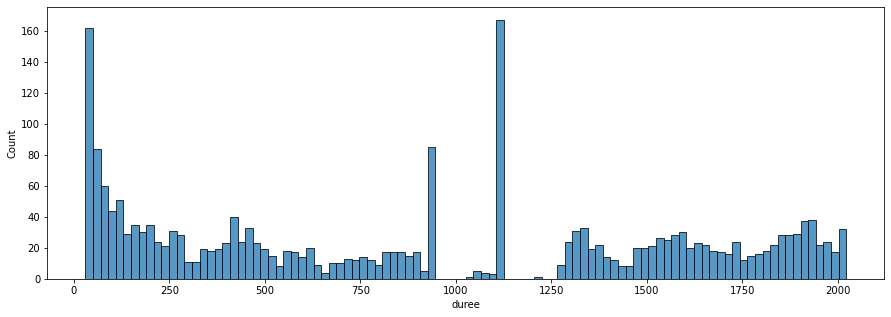

In [36]:
plt.figure(figsize=(15,5))
sns.histplot(data=ctx, x="duree", bins=100)

# on analyse les valeurs contenues dans le bloc B_
L'objectif est de n'avoir que des valeurs en lien avec les contentieux.

In [14]:
for c in ['B_streetnumber','B_streettype','B_address','B_address2','B_city',
          'B_state','B_zipcode','B_country','B_email','B_phone', 'contactnote']:
    print(c)
    print(adh_bloc_ctx[c].value_counts())
    print('---------------------------------------')

B_streetnumber
Series([], Name: B_streetnumber, dtype: int64)
---------------------------------------
B_streettype
Series([], Name: B_streettype, dtype: int64)
---------------------------------------
B_address
2023-01-14    95
2022-07-06    93
2021-10-22    86
2021-01-28    78
2021-08-10    75
              ..
2020-10-23     1
2020-08-21     1
2021-08-11     1
2020-09-05     1
2023-06-23     1
Name: B_address, Length: 164, dtype: int64
---------------------------------------
B_address2
message vocal        1582
usager joint          888
téléphone inconnu     721
Name: B_address2, dtype: int64
---------------------------------------
B_city
2023-01-25    26
2021-05-22    26
2021-07-27    26
2021-04-06    25
2022-05-21    25
              ..
2021-01-27     1
2022-07-06     1
2021-07-24     1
2021-02-03     1
2021-01-28     1
Name: B_city, Length: 143, dtype: int64
---------------------------------------
B_state
0           500
20210064      6
20220102      6
20220101      5
20220214      

On constate que 'B_streetnumber','B_streettype','B_email' et 'B_phone' ne contiennent aucune info, on peut donc les supprimer du dataframe.

In [15]:
adh_bloc_ctx = adh_bloc_ctx.drop(columns=['B_streetnumber','B_streettype','B_email', 'B_phone'])

In [16]:
adh_bloc_ctx

,borrowernumber,cardnumber,userid,B_address,B_address2,B_city,B_state,B_zipcode,B_country,contactnote,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
0,9.0,X0002058641,X0002058641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-09-11,MED,BIBL,2007-05-02,2021-12-02,NaN,False
1,15.0,X0001920261,X0001920261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-08,MED,BIBL,2013-03-30,2021-09-29,NaN,False
2,25.0,X0002404233,X0002404233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-08-07,MED,BIBL,2009-07-17,2023-12-30,NaN,False
3,28.0,X0001659292,X0001659292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-21,MED,BIBL,2012-02-08,2022-09-18,NaN,False
4,42.0,X0002437651,X0002437651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-10-23,MED,BIBL,2005-03-31,2021-08-18,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26485,73521.0,X0002747668,X0002747668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-07,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26486,73522.0,X0002747101,X0002747101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972-03-09,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26487,73523.0,X0002747095,X0002747095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-07,MED,CSLT,2023-07-18,2024-07-18,NaN,False
26488,73524.0,X0002747040,X0002747040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08,MED,BIBL,2023-07-18,2024-07-18,NaN,False


In [17]:
# ppur plus de facilité, on peut renommer les champs dédiés à la gestion des contentieux
adh_bloc_ctx = adh_bloc_ctx.rename(columns={"B_address":"date_appel_telephonique",
                              "B_address2":"resultat_appel",
                              "B_city":"date_demande_creation_tiers",
                              "B_state":"numero_titre_recette",
                              "B_zipcode":"numero_tiers_GF",
                              "B_country":"date_creation_titre_recette",
                              "contactnote":"documents_a_payer"})

In [18]:
adh_bloc_ctx

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
0,9.0,X0002058641,X0002058641,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2002-09-11,MED,BIBL,2007-05-02,2021-12-02,NaN,False
1,15.0,X0001920261,X0001920261,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2009-09-08,MED,BIBL,2013-03-30,2021-09-29,NaN,False
2,25.0,X0002404233,X0002404233,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996-08-07,MED,BIBL,2009-07-17,2023-12-30,NaN,False
3,28.0,X0001659292,X0001659292,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007-12-21,MED,BIBL,2012-02-08,2022-09-18,NaN,False
4,42.0,X0002437651,X0002437651,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1970-10-23,MED,BIBL,2005-03-31,2021-08-18,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26485,73521.0,X0002747668,X0002747668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-10-07,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26486,73522.0,X0002747101,X0002747101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1972-03-09,MED,BIBL,2023-07-18,2024-07-18,NaN,False
26487,73523.0,X0002747095,X0002747095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1997-06-07,MED,CSLT,2023-07-18,2024-07-18,NaN,False
26488,73524.0,X0002747040,X0002747040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-06-08,MED,BIBL,2023-07-18,2024-07-18,NaN,False


In [19]:
adh_bloc_ctx_with_data = adh_bloc_ctx[(~adh_bloc_ctx['date_appel_telephonique'].isna())
                                    | (~adh_bloc_ctx['resultat_appel'].isna())
                                    | (~adh_bloc_ctx['date_demande_creation_tiers'].isna())
                                    | (~adh_bloc_ctx['numero_titre_recette'].isna())
                                    | (~adh_bloc_ctx['numero_tiers_GF'].isna())
                                    | (~adh_bloc_ctx['date_creation_titre_recette'].isna())
                                    | (~adh_bloc_ctx['documents_a_payer'].isna())]
adh_bloc_ctx_with_data

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux
8,72.0,X0002315447,X0002315447,2021-01-19,usager joint,2021-02-09,20210034,91611,2021-02-09,C0005382767\r\nC2500004195\r\nC2500012698\r\nC...,2012-04-05,MED,BIBL,2019-10-22,2021-06-22,2019-11-12,True
27,203.0,X0001954258,X0001954258,2021-02-06,message vocal,NaN,NaN,NaN,NaN,NaN,1998-08-04,MED,BIBL,2011-12-10,2023-05-07,NaN,False
30,212.0,X0002003986,X0002003986,2021-10-22,message vocal,NaN,NaN,NaN,NaN,NaN,2002-06-08,MED,BIBL,2013-10-02,2021-10-21,NaN,False
31,215.0,X0002094755,X0002094755,2023-05-17,usager joint,NaN,NaN,NaN,NaN,NaN,1980-08-29,MED,MEDB,2008-06-13,2023-08-26,NaN,False
32,237.0,X0002217536,X0002217536,NaN,NaN,NaN,NaN,NaN,2019-08-27,Titre émis avant 2021,2000-06-30,MED,BIBL,2011-05-06,2018-07-11,2018-02-24,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25663,72670.0,X0002654768,X0002654768,2023-04-04,message vocal,NaN,NaN,NaN,NaN,NaN,2016-03-31,MED,BIBL,2023-05-06,2024-05-06,2023-06-03,True
25728,72735.0,X0002609010,X0002609010,2023-05-03,message vocal,NaN,NaN,NaN,NaN,NaN,1973-05-09,MED,BIBL,2023-05-10,2024-05-10,NaN,False
25907,72914.0,X0002611129,X0002611129,NaN,NaN,NaN,NaN,92421,NaN,NaN,2016-05-26,MED,BIBL,2023-05-24,2024-05-24,NaN,False
25926,72933.0,X0002744513,X0002744513,2022-11-05,message vocal,2023-04-29,0,0,2023-04-29,C2500011914 - 10.95,2014-01-03,MED,BIBL,2023-05-25,2024-05-25,NaN,False


In [21]:
adh_bloc_ctx_with_data_pb[adh_bloc_ctx_with_data_pb['contentieux'] ==  False]

,borrowernumber,cardnumber,userid,date_appel_telephonique,resultat_appel,date_demande_creation_tiers,numero_titre_recette,numero_tiers_GF,date_creation_titre_recette,documents_a_payer,dateofbirth,branchcode,categorycode,dateenrolled,dateexpiry,date_due,contentieux


In [22]:
adh_bloc_ctx_with_data_pb.groupby("contentieux").size()

Series([], dtype: int64)

vérifier si pour ces cartes les colonnes contentieux peuvent être mises à Null

# Cartes avec données de contentieux sans contentieux

Explication de la requête ci dessous : 
* ligne 1 : `adh_bloc_ctx_with_data_without_ctx` = tous les documents de `adh_bloc_ctx_with_data` dont le `borrowernumber` ne correspond pas au borrowernumber des documents en contentieux qui ont une erreur de graphie (`adh_bloc_ctx_with_data_pb` )`adh_bloc_ctx_with_data_pb`)

a priori, données de contentieux à supprimer : attention à possibilité de faire des stats

In [25]:
data = {"B_address": None,
        "B_address2": None,
        "B_city": None,
        "B_state": None,
        "B_zipcode": None,
        "B_country": None,
        "contactnote": None}
userid = 'X0002525563'
mod_borrower(userid, data)

data={"B_address": null, "B_address2": null, "B_city": null, "B_state": null, "B_zipcode": null, "B_country": null, "contactnote": null}
X0002525563 : b'{\n   "modified_fields" : {},\n   "success" : true\n}\n'


In [52]:
query = """SELECT i.borrowernumber, DATE(i.date_due) as date_due, b.B_address2, b.B_state
FROM koha_prod.issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE i.date_due < CURDATE() - INTERVAL 1 DAY
AND b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
retard = pd.read_sql(query, db_conn)

In [53]:
retard = retard.drop_duplicates(subset='borrowernumber')
retard['date_due'] = pd.to_datetime(retard['date_due'])
retard['retard_jours'] = (datetime.now() - retard['date_due']).dt.days

<AxesSubplot:xlabel='retard_jours', ylabel='Count'>

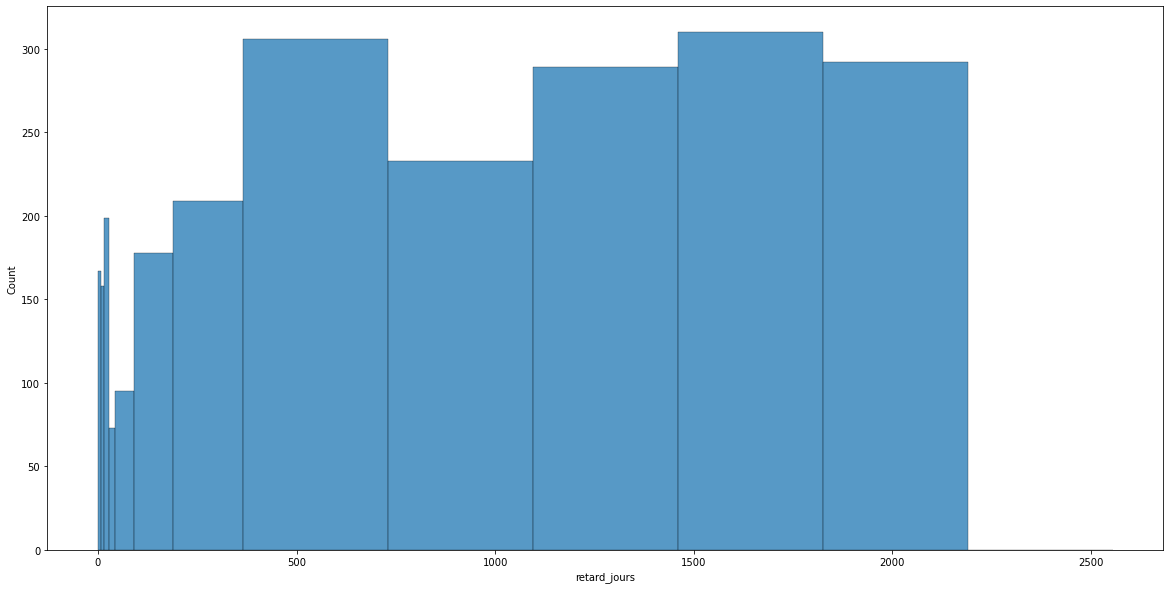

In [54]:
plt.figure(figsize=(20,10))
sns.histplot(data=retard[retard['retard_jours'] >= 1 ],
             x="retard_jours",
             log_scale = (False, False),
             bins=[0, 7, 14, 28, 42, 90, 190, 365, 730, 1095, 1460, 1825, 2190, 2555])

In [55]:
retard

,borrowernumber,date_due,B_address2,B_state,retard_jours
0,15475,2018-01-03,,,2101
2,23197,2018-01-03,,,2101
3,44282,2018-01-03,message vocal,,2101
6,45054,2018-01-04,,,2100
7,45190,2018-01-04,,,2100
...,...,...,...,...,...
7605,73093,2023-10-03,,,2
7606,73320,2023-10-03,,,2
7607,73455,2023-10-03,,,2
7612,73891,2023-10-03,,,2


In [58]:
r = retard['retard_jours']
tr = [0, 7, 14, 28, 42, 90, 180, 365, 730, 1095, 1460, 1825, 2190]
res = pd.cut(r,
             tr,
             labels=["Moins d'une semaine",
                     "D'une à deux semaines",
                     "De deux à quatre semaines",
                     "De quatre à six semaines",
                     "De six semaines à trois mois",
                     "De trois à 6 mois",
                     "De 6 mois à un an",
                     "De un à deux ans",
                     "De deux à trois ans",
                     "De trois à quatre ans",
                     "De quatre à cinq ans",
                     "De cinq à six ans"],
             include_lowest=True, right=False)
res















0         De cinq à six ans
2         De cinq à six ans
3         De cinq à six ans
6         De cinq à six ans
7         De cinq à six ans
               ...         
7605    Moins d'une semaine
7606    Moins d'une semaine
7607    Moins d'une semaine
7612    Moins d'une semaine
7617    Moins d'une semaine
Name: retard_jours, Length: 2509, dtype: category
Categories (12, object): ['Moins d'une semaine' < 'D'une à deux semaines' < 'De deux à quatre semaines' < 'De quatre à six semaines' ... 'De deux à trois ans' < 'De trois à quatre ans' < 'De quatre à cinq ans' < 'De cinq à six ans']

In [63]:
retard_enrichi = pd.merge(retard, res, left_index=True, right_index=True)

In [65]:
retard_enrichi = retard_enrichi.rename(columns={'B_address2': 'appel', 'B_state': 'titre_recette'})
retard_enrichi

,borrowernumber,date_due,appel,titre_recette,retard_jours_x,retard_jours_y
0,15475,2018-01-03,,,2101,De cinq à six ans
2,23197,2018-01-03,,,2101,De cinq à six ans
3,44282,2018-01-03,message vocal,,2101,De cinq à six ans
6,45054,2018-01-04,,,2100,De cinq à six ans
7,45190,2018-01-04,,,2100,De cinq à six ans
...,...,...,...,...,...,...
7605,73093,2023-10-03,,,2,Moins d'une semaine
7606,73320,2023-10-03,,,2,Moins d'une semaine
7607,73455,2023-10-03,,,2,Moins d'une semaine
7612,73891,2023-10-03,,,2,Moins d'une semaine


In [67]:
retard_enrichi.loc[retard_enrichi['titre_recette'] != '', 'titre_recette'] = True


In [73]:
retard_enrichi.groupby(['retard_jours_y', 'appel'])['borrowernumber'].count()

retard_jours_y                appel            
Moins d'une semaine                                149
                              message vocal          5
                              téléphone inconnu      0
                              usager joint           6
D'une à deux semaines                              132
                              message vocal          4
                              téléphone inconnu      1
                              usager joint           2
De deux à quatre semaines                          146
                              message vocal          5
                              téléphone inconnu      4
                              usager joint           6
De quatre à six semaines                            51
                              message vocal          3
                              téléphone inconnu      1
                              usager joint           1
De six semaines à trois mois                        24
                 

In [56]:
res.value_counts()

10 Cinq ans           310
07 Deux ans           306
11 Six ans            292
09 Quatre ans         289
08 Trois ans          233
06 Un an              222
02 Quatre semaines    199
00 Une semaine        167
05 Six mois           165
01 Deux semaines      158
04 Trois mois          95
03 Six semaines        73
Name: retard_jours, dtype: int64

In [51]:
query = """SELECT i.borrowernumber, DATE(i.date_due), DATE(i.returndate)
FROM koha_prod.issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
issues1401 = pd.read_sql(query, db_conn)
print(len(issues1401))
query = """SELECT i.borrowernumber, DATE(i.date_due), DATE(i.returndate)
FROM koha_prod.old_issues i
JOIN koha_prod.borrowers b ON b.borrowernumber = i.borrowernumber
WHERE b.categorycode IN ('BIBL', 'MEDA', 'MEDB','MEDC', 'CSVT')
ORDER BY i.date_due"""
issues1401b = pd.read_sql(query, db_conn)
print(len(issues1401b))
issues1401 = pd.concat([issues1401, issues1401b])
print(len(issues1401))

26710
98920
125630
